# Recriar Estudo 2 - Treino com o UAVS (Raw Images)

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-25 07:49:28.727006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-25 07:49:30.031706: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1147417114392559323
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6043006243245127229
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-25 07:49:31.925635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 07:49:32.047356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 07:49:32.047407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 07:49:32.234886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 07:49:32.234960: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, ReLU, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-25 07:49:32.246639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 07:49:32.246877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 07:49:32.246918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
# Entrada
input_layer = Input(shape=(224, 224, 3))

# Primeira camada
x = Conv2D(48, (3,3), strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_1
for _ in range(2):
    x = Conv2D(72, (1,1), strides=1, padding='same')(x)  # 24 -> 72
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(24, (1,1), strides=1, padding='same')(x)  # 72 -> 24
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
# Expandir de novo
x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(56, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_2
for _ in range(2):
    x = Conv2D(168, (1,1), strides=1, padding='same')(x)  # 56 -> 168
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(56, (1,1), strides=1, padding='same')(x)  # 168 -> 56
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir de novo
x = Conv2D(336, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(104, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_3
for _ in range(2):
    x = Conv2D(624, (1,1), strides=1, padding='same')(x)  # 104 -> 624
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(104, (1,1), strides=1, padding='same')(x)  # 624 -> 104
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir
x = Conv2D(624, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_4
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Entre conv_blocks
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(272, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_5
for _ in range(3):
    x = Conv2D(1632, (1,1), strides=1, padding='same')(x)  # 272 -> 1632
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(272, (1,1), strides=1, padding='same')(x)  # 1632 -> 272
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Finalização
x = Conv2D(1632, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(448, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(1280, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Pooling global e classificação
x = GlobalAveragePooling2D()(x)
output_layer = Dense(2, activation='softmax')(x)

# Modelo
model = Model(inputs=input_layer, outputs=output_layer)

2025-06-25 07:49:33.210829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 07:49:33.210930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 07:49:33.210965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 07:49:33.211218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 07:49:33.211230: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 48)      1344      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 48)      192       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 48)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 48)      480       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 48)      192   

## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Categorical crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs, eps, 1 - eps)
    y = y_true
    loss = -np.mean(np.sum(y * np.log(p), axis=1))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths = data['image_path'].values
labels = data['label_bi'].values

data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_test = data['image_path'].values
labels_test = data['label_bi'].values

In [13]:
# Dividir em treino, validação e teste (80/10/10)
x_train, x_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.1, random_state=SEED, stratify=labels)

In [14]:
# Criar datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
inspect_dataset_distribution(train_ds, name="train")
inspect_dataset_distribution(val_ds, name="val")
inspect_dataset_distribution(test_ds, name="test")

📊 TRAIN -> Total de imagens: 1478
  Classe 0 (Sem fogo): 448 imagens (30.31%)
  Classe 1 (Fogo): 1030 imagens (69.69%)
----------------------------------------
📊 VAL -> Total de imagens: 165
  Classe 0 (Sem fogo): 50 imagens (30.30%)
  Classe 1 (Fogo): 115 imagens (69.70%)
----------------------------------------
📊 TEST -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [16]:
callback = [
    ModelCheckpoint('Recriar_Estudo_2_UAVS_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [17]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)

Epoch 1/50


2025-06-25 07:50:00.539244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-06-25 07:50:02.116517: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x782f145b58f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-25 07:50:02.116563: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-25 07:50:02.186290: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-25 07:50:02.454631: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-25 07:50:02.622750: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The c

92/93 [============================>.] - ETA: 0s - loss: 0.4131 - accuracy: 0.8512 - precision: 0.8512 - recall: 0.8512 - auc: 0.9122 - f1_score: 0.8231

2025-06-25 07:50:33.343182: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-25 07:50:33.343247: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


93/93 [==============================] - ETA: 0s - loss: 0.4140 - accuracy: 0.8512 - precision: 0.8512 - recall: 0.8512 - auc: 0.9119 - f1_score: 0.8232
Epoch 1: val_loss improved from inf to 0.78837, saving model to Recriar_Estudo_2_UAVS_best.h5


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - 46s 181ms/step - loss: 0.4140 - accuracy: 0.8512 - precision: 0.8512 - recall: 0.8512 - auc: 0.9119 - f1_score: 0.8232 - val_loss: 0.7884 - val_accuracy: 0.6970 - val_precision: 0.6970 - val_recall: 0.6970 - val_auc: 0.6970 - val_f1_score: 0.4107
Epoch 2/50
93/93 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9828 - f1_score: 0.9277
Epoch 2: val_loss did not improve from 0.78837
93/93 [==============================] - 14s 140ms/step - loss: 0.1598 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9828 - f1_score: 0.9277 - val_loss: 1.0718 - val_accuracy: 0.6970 - val_precision: 0.6970 - val_recall: 0.6970 - val_auc: 0.6970 - val_f1_score: 0.4107
Epoch 3/50
93/93 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9892 - f1_score: 0.9492
Epoch 3: val_loss did not improve from 0.78837
93

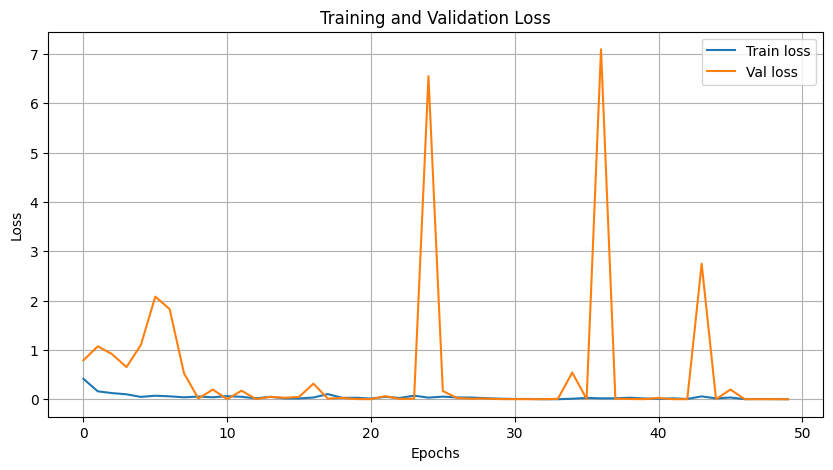

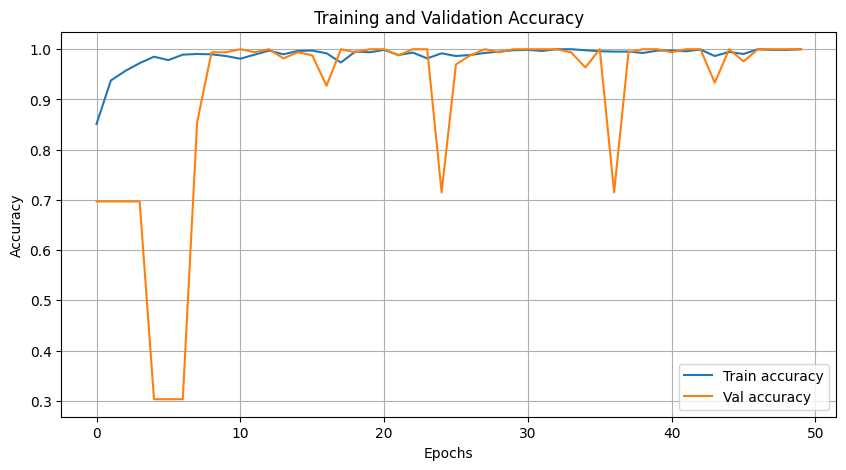

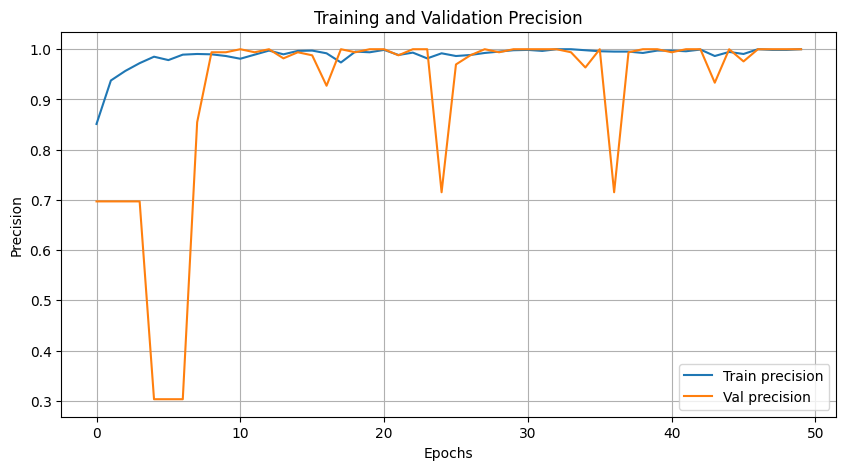

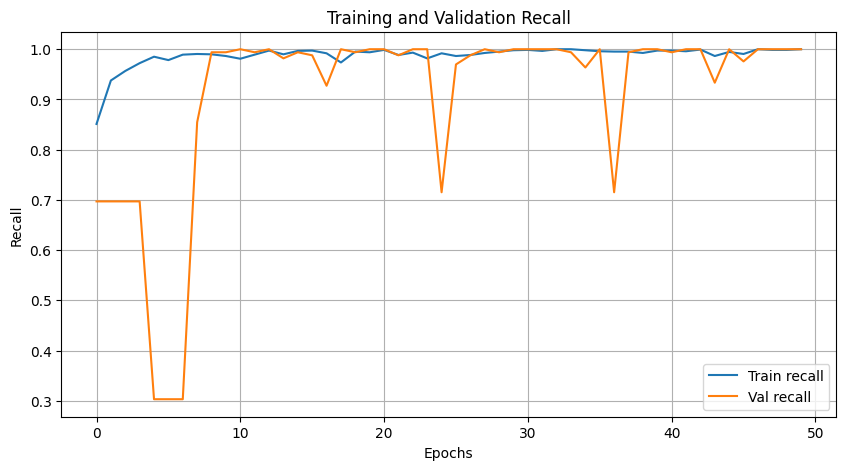

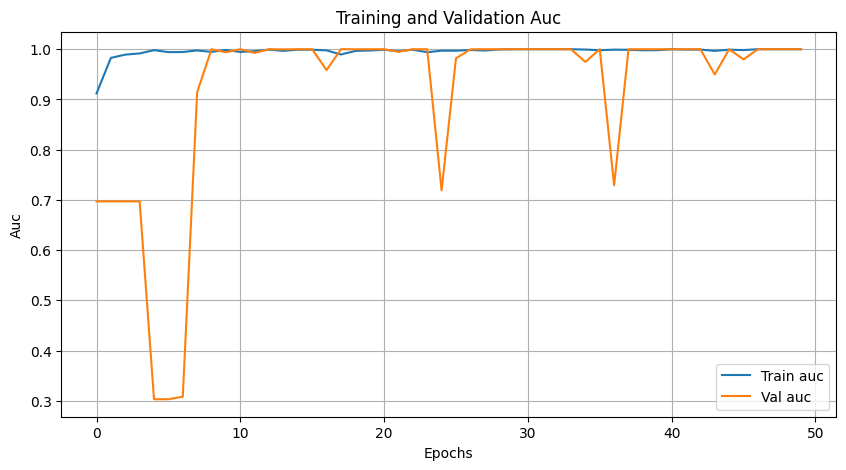

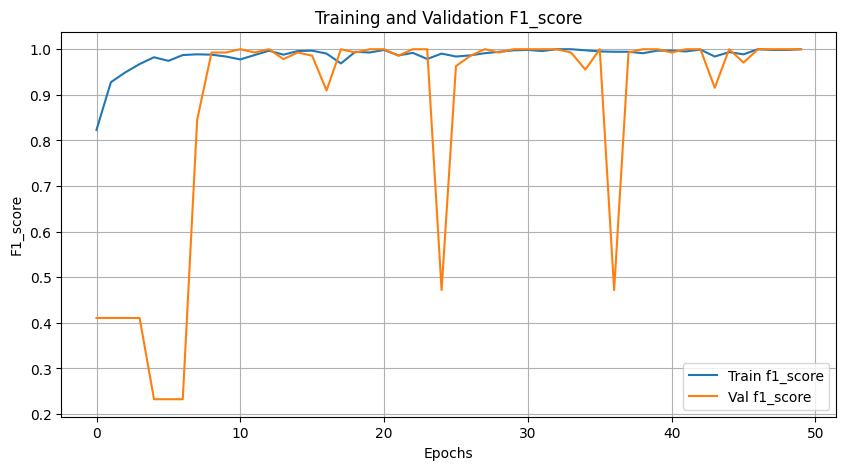

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('Recriar_Estudo_2_UAVS_train_history.csv', index=False)

In [20]:
model.save('Recriar_Estudo_2_UAVS.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [ ]:
model = load_model('Recriar_Estudo_2_UAVS.h5')

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7190, TN=7722, FP=58, FN=590
Accuracy       : 0.9584
Precision      : 0.9920
Recall         : 0.9242
F1-Score       : 0.9569
AUC            : 0.9956
Binary Loss    : 0.1734
FDR (Fire Detection Rate)      : 92.42 %
EWR (Error Warning Rate)       : 4.16 %
Confusion Matrix:
[[7722   58]
 [ 590 7190]]


{'TP': 7190,
 'TN': 7722,
 'FP': 58,
 'FN': 590,
 'accuracy': 0.9583547557840617,
 'precision': 0.9919977924944813,
 'recall': 0.9241645244215938,
 'f1_score': 0.9568804897524621,
 'auc': 0.9955768862220049,
 'loss': 0.17342449498035772,
 'fdr': 92.41645244215938,
 'ewr': 4.16452442159383,
 'confusion_matrix': array([[7722,   58],
        [ 590, 7190]])}

In [22]:
model_best = load_model('Recriar_Estudo_2_UAVS_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7595, TN=7469, FP=311, FN=185
Accuracy       : 0.9681
Precision      : 0.9607
Recall         : 0.9762
F1-Score       : 0.9684
AUC            : 0.9874
Binary Loss    : 0.3679
FDR (Fire Detection Rate)      : 97.62 %
EWR (Error Warning Rate)       : 3.19 %
Confusion Matrix:
[[7469  311]
 [ 185 7595]]


{'TP': 7595,
 'TN': 7469,
 'FP': 311,
 'FN': 185,
 'accuracy': 0.9681233933161953,
 'precision': 0.9606627877561346,
 'recall': 0.9762210796915167,
 'f1_score': 0.9683794466403162,
 'auc': 0.9874229122197183,
 'loss': 0.36792233789736706,
 'fdr': 97.62210796915167,
 'ewr': 3.1876606683804627,
 'confusion_matrix': array([[7469,  311],
        [ 185, 7595]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=639, TN=7620, FP=6737, FN=24379
Accuracy       : 0.2098
Precision      : 0.0866
Recall         : 0.0255
F1-Score       : 0.0395
AUC            : 0.4270
Binary Loss    : 5.9934
FDR (Fire Detection Rate)      : 2.55 %
EWR (Error Warning Rate)       : 79.02 %
Confusion Matrix:
[[ 7620  6737]
 [24379   639]]


{'TP': 639,
 'TN': 7620,
 'FP': 6737,
 'FN': 24379,
 'accuracy': 0.20975238095238094,
 'precision': 0.08663232104121475,
 'recall': 0.025541610040770647,
 'f1_score': 0.0394517503241341,
 'auc': 0.4270445791671913,
 'loss': 5.993384866080551,
 'fdr': 2.5541610040770646,
 'ewr': 79.0247619047619,
 'confusion_matrix': array([[ 7620,  6737],
        [24379,   639]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=101, TN=7245, FP=7112, FN=24917
Accuracy       : 0.1866
Precision      : 0.0140
Recall         : 0.0040
F1-Score       : 0.0063
AUC            : 0.0679
Binary Loss    : 12.9512
FDR (Fire Detection Rate)      : 0.40 %
EWR (Error Warning Rate)       : 81.34 %
Confusion Matrix:
[[ 7245  7112]
 [24917   101]]


{'TP': 101,
 'TN': 7245,
 'FP': 7112,
 'FN': 24917,
 'accuracy': 0.18656507936507938,
 'precision': 0.0140024954942465,
 'recall': 0.004037093292829163,
 'f1_score': 0.00626725822965468,
 'auc': 0.06786093465236895,
 'loss': 12.951168670797191,
 'fdr': 0.4037093292829163,
 'ewr': 81.34349206349206,
 'confusion_matrix': array([[ 7245,  7112],
        [24917,   101]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=109, TN=3336, FP=144, FN=5028
Accuracy       : 0.3998
Precision      : 0.4308
Recall         : 0.0212
F1-Score       : 0.0404
AUC            : 0.4644
Binary Loss    : 3.8805
FDR (Fire Detection Rate)      : 2.12 %
EWR (Error Warning Rate)       : 60.02 %
Confusion Matrix:
[[3336  144]
 [5028  109]]


{'TP': 109,
 'TN': 3336,
 'FP': 144,
 'FN': 5028,
 'accuracy': 0.3997911105953348,
 'precision': 0.4308300395256917,
 'recall': 0.021218610083706443,
 'f1_score': 0.040445269016697594,
 'auc': 0.4643716758517763,
 'loss': 3.880488116081157,
 'fdr': 2.121861008370644,
 'ewr': 60.02088894046652,
 'confusion_matrix': array([[3336,  144],
        [5028,  109]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=356, TN=3325, FP=155, FN=4781
Accuracy       : 0.4272
Precision      : 0.6967
Recall         : 0.0693
F1-Score       : 0.1261
AUC            : 0.4853
Binary Loss    : 8.8205
FDR (Fire Detection Rate)      : 6.93 %
EWR (Error Warning Rate)       : 57.28 %
Confusion Matrix:
[[3325  155]
 [4781  356]]


{'TP': 356,
 'TN': 3325,
 'FP': 155,
 'FN': 4781,
 'accuracy': 0.42717883254032724,
 'precision': 0.6966731898238747,
 'recall': 0.06930114853027058,
 'f1_score': 0.12606232294617564,
 'auc': 0.48530318133711026,
 'loss': 8.82054022443541,
 'fdr': 6.930114853027058,
 'ewr': 57.28211674596727,
 'confusion_matrix': array([[3325,  155],
        [4781,  356]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=498, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0002
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 498    0]
 [   0 1145]]


{'TP': 1145,
 'TN': 498,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 1.0,
 'loss': 0.00022990540430151976,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 498,    0],
        [   0, 1145]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1140, TN=497, FP=1, FN=5
Accuracy       : 0.9963
Precision      : 0.9991
Recall         : 0.9956
F1-Score       : 0.9974
AUC            : 0.9986
Binary Loss    : 0.0385
FDR (Fire Detection Rate)      : 99.56 %
EWR (Error Warning Rate)       : 0.37 %
Confusion Matrix:
[[ 497    1]
 [   5 1140]]


{'TP': 1140,
 'TN': 497,
 'FP': 1,
 'FN': 5,
 'accuracy': 0.9963481436396835,
 'precision': 0.9991235758106923,
 'recall': 0.9956331877729258,
 'f1_score': 0.9973753280839895,
 'auc': 0.9986110380386174,
 'loss': 0.03850392580834793,
 'fdr': 99.56331877729258,
 'ewr': 0.36518563603164944,
 'confusion_matrix': array([[ 497,    1],
        [   5, 1140]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7190, TN=7722, FP=58, FN=590
Accuracy       : 0.9584
Precision      : 0.9920
Recall         : 0.9242
F1-Score       : 0.9569
AUC            : 0.9956
Binary Loss    : 0.1734
FDR (Fire Detection Rate)      : 92.42 %
EWR (Error Warning Rate)       : 4.16 %
Confusion Matrix:
[[7722   58]
 [ 590 7190]]


{'TP': 7190,
 'TN': 7722,
 'FP': 58,
 'FN': 590,
 'accuracy': 0.9583547557840617,
 'precision': 0.9919977924944813,
 'recall': 0.9241645244215938,
 'f1_score': 0.9568804897524621,
 'auc': 0.9955768862220049,
 'loss': 0.17342449498035772,
 'fdr': 92.41645244215938,
 'ewr': 4.16452442159383,
 'confusion_matrix': array([[7722,   58],
        [ 590, 7190]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7595, TN=7469, FP=311, FN=185
Accuracy       : 0.9681
Precision      : 0.9607
Recall         : 0.9762
F1-Score       : 0.9684
AUC            : 0.9874
Binary Loss    : 0.3679
FDR (Fire Detection Rate)      : 97.62 %
EWR (Error Warning Rate)       : 3.19 %
Confusion Matrix:
[[7469  311]
 [ 185 7595]]


{'TP': 7595,
 'TN': 7469,
 'FP': 311,
 'FN': 185,
 'accuracy': 0.9681233933161953,
 'precision': 0.9606627877561346,
 'recall': 0.9762210796915167,
 'f1_score': 0.9683794466403162,
 'auc': 0.9874229122197183,
 'loss': 0.36792233789736706,
 'fdr': 97.62210796915167,
 'ewr': 3.1876606683804627,
 'confusion_matrix': array([[7469,  311],
        [ 185, 7595]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=254, TN=0, FP=33, FN=302
Accuracy       : 0.4312
Precision      : 0.8850
Recall         : 0.4568
F1-Score       : 0.6026
AUC            : 0.0491
Binary Loss    : 4.1049
FDR (Fire Detection Rate)      : 45.68 %
EWR (Error Warning Rate)       : 56.88 %
Confusion Matrix:
[[  0  33]
 [302 254]]


{'TP': 254,
 'TN': 0,
 'FP': 33,
 'FN': 302,
 'accuracy': 0.4312393887945671,
 'precision': 0.8850174216027874,
 'recall': 0.4568345323741007,
 'f1_score': 0.6026097271648873,
 'auc': 0.04913342053629824,
 'loss': 4.10488638546485,
 'fdr': 45.68345323741007,
 'ewr': 56.8760611205433,
 'confusion_matrix': array([[  0,  33],
        [302, 254]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=328, TN=0, FP=33, FN=228
Accuracy       : 0.5569
Precision      : 0.9086
Recall         : 0.5899
F1-Score       : 0.7154
AUC            : 0.2095
Binary Loss    : 5.7776
FDR (Fire Detection Rate)      : 58.99 %
EWR (Error Warning Rate)       : 44.31 %
Confusion Matrix:
[[  0  33]
 [228 328]]


{'TP': 328,
 'TN': 0,
 'FP': 33,
 'FN': 228,
 'accuracy': 0.5568760611205433,
 'precision': 0.9085872576177285,
 'recall': 0.5899280575539568,
 'f1_score': 0.7153762268266084,
 'auc': 0.20953237410071943,
 'loss': 5.777590776268222,
 'fdr': 58.992805755395686,
 'ewr': 44.312393887945674,
 'confusion_matrix': array([[  0,  33],
        [228, 328]])}